**<h3>1 Water pump prediction<h3>**

### 1.1 Library insertion

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import chi2_contingency

### 1.2 Data insertion and variable creation

In [2]:
training_data_value = pd.read_csv("../Data/Training_set_values.csv")
training_data_label = pd.read_csv("../Data/Training_set_labels.csv")
testing_data = pd.read_csv("../Data/Test_set_values.csv")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# merge data
ex_data_list = []
Merged_training_data = pd.merge(training_data_value,training_data_label, on="id")
All_data = pd.concat([testing_data, Merged_training_data])
All_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,50785,0.0,4/2/2013,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN
1,51630,0.0,4/2/2013,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN
2,17168,0.0,1/2/2013,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN
3,45559,0.0,22/1/2013,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN
4,49871,500.0,27/3/2013,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN


### 1.3 Support function

In [3]:
# support function for numerical data, for analysis whole dataframe
def numerical_analysis(dataFrame):
  
  # Only select numerical columns
  numerical = dataFrame.select_dtypes(include = ['int', 'Int64', 'float']).columns.tolist()
  
  #data type
  data_types = pd.DataFrame(dataFrame[numerical].dtypes,columns=['Data Type'])

  # number of data count
  count_val = pd.DataFrame(columns=['Count'])

  for row in list(dataFrame[numerical].columns.values):
      count_val.loc[row] = [dataFrame[numerical][row].count()]
    
  # missing data
  missing_data = pd.DataFrame(dataFrame[numerical].isnull().sum(),columns=['Missing Values'])

  # maximum value
  maximum_val = pd.DataFrame(columns=['Maximum'])

  for row in list(dataFrame[numerical].columns.values):
      maximum_val.loc[row] = [dataFrame[numerical][row].max()]
    
  # minimum value
  minimum_val = pd.DataFrame(columns=['Minimum'])

  for row in list(dataFrame[numerical].columns.values):
      minimum_val.loc[row] = [dataFrame[numerical][row].min()]
    
  # mean value
  mean_val= pd.DataFrame(columns=['Mean'])

  for row in list(dataFrame[numerical].columns.values):
      mean_val.loc[row] = [dataFrame[numerical][row].mean()]

  # standard deviation value
  sd_val = pd.DataFrame(columns=['Standard Deviation'])

  for row in list(dataFrame[numerical].columns.values):
      sd_val.loc[row] = [dataFrame[numerical][row].std()]

  # mode
  mode_val = pd.DataFrame(columns=['Mode'])

  for row in list(dataFrame[numerical].columns.values): 
    mode_val.loc[row] = [dataFrame[numerical][row].mode()[0]]
    mode_0 = mode_val.loc[row]
  
  # mode frequency
  count_f_list = []

  for row in numerical:
    mode_0 = dataFrame[row].mode().iat[0]
    count_f = dataFrame[row].value_counts()[mode_0]
    count_f_list.append(count_f)

  count_f_list = np.array(count_f_list)
    
  # First quartile
  IqR_1 = pd.DataFrame(columns=['1st Quartile'])

  for row in list(dataFrame[numerical].columns.values):
      IqR_1.loc[row] = [dataFrame[numerical][row].quantile(0.25)]
    
  # Median
  median = pd.DataFrame(columns=['Median'])

  for row in list(dataFrame[numerical].columns.values):
    median.loc[row] = [dataFrame[numerical][row].quantile(0.5)]
    
  # Third quartile
  IqR_3 = pd.DataFrame(columns=['3rd Quartile'])

  for row in list(dataFrame[numerical].columns.values):
    IqR_3.loc[row] = [dataFrame[numerical][row].quantile(0.75)]

  # Unique values
  unique_val = pd.DataFrame(columns=['Unique Values'])

  for row in list(dataFrame[numerical].columns.values):
    unique_val.loc[row] = [dataFrame[numerical][row].nunique()]
  
    
  # join columns 
  result = data_types.join(count_val).join(missing_data).join(unique_val).join(minimum_val).join(maximum_val).join(mean_val).join(sd_val).join(IqR_1).join(median).join(IqR_3).join(mode_val)
  
  # percentage missing
  result['Missing in %'] = (result['Missing Values'] / len(dataFrame[numerical]) *100)
  
  # alternative mode calculation
  result['Mode freq'] = count_f_list 
  result['Mode in %'] = (result['Mode freq'] / result['Count']*100).astype('float')


  # change order of columns
  result = result[['Data Type', 'Count', 'Missing Values', 'Missing in %','Unique Values', 'Mean', 'Standard Deviation', 'Minimum', '1st Quartile', 'Median', '3rd Quartile', 'Maximum', 'Mode', 'Mode freq','Mode in %']]

  #round
  result[['Missing in %', 'Mean', 'Standard Deviation', 'Minimum', '1st Quartile', 'Median', '3rd Quartile', 'Maximum','Mode freq','Mode in %','Mode']] =  result[['Missing in %', 'Mean', 'Standard Deviation', 'Minimum', '1st Quartile', 'Median', '3rd Quartile', 'Maximum', 'Mode freq','Mode in %','Mode']].round(1)
  
   
  #rreturn report
  return(result)


In [4]:
num_analysis = numerical_analysis(All_data)
num_analysis

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
id,int64,74250,0,0.0,74250,37124.5,21434.3,0.0,18562.2,37124.5,55686.8,74249.0,0.0,1,0.0
amount_tsh,float64,74250,0,0.0,102,318.7,2906.8,0.0,0.0,0.0,20.0,350000.0,0.0,52049,70.1
gps_height,int64,74250,0,0.0,2456,665.7,692.8,-90.0,0.0,364.0,1317.0,2777.0,0.0,25649,34.5
longitude,float64,74250,0,0.0,71870,34.1,6.6,0.0,33.1,34.9,37.2,40.3,0.0,2269,3.1
latitude,float64,74250,0,0.0,71869,-5.7,2.9,-11.6,-8.5,-5.0,-3.3,-0.0,-0.0,2269,3.1
num_private,int64,74250,0,0.0,68,0.5,11.5,0.0,0.0,0.0,0.0,1776.0,0.0,73299,98.7
region_code,int64,74250,0,0.0,27,15.3,17.5,1.0,5.0,12.0,17.0,99.0,11.0,6608,8.9
district_code,int64,74250,0,0.0,20,5.6,9.6,0.0,2.0,3.0,5.0,80.0,1.0,15299,20.6
population,int64,74250,0,0.0,1128,180.8,471.1,0.0,0.0,25.0,215.0,30500.0,0.0,26834,36.1
construction_year,int64,74250,0,0.0,55,1298.5,952.3,0.0,0.0,1986.0,2004.0,2013.0,0.0,25969,35.0


In [5]:
def categorical_analysis(dataFrame):

    # Select categorical columns
    cat_columns = dataFrame.select_dtypes(include='object').columns.tolist()

    # Data types
    data_types = pd.DataFrame(dataFrame[cat_columns].dtypes,columns=['Data Type'])


    # Missing data
    missing_df = pd.DataFrame(dataFrame[cat_columns].isnull().sum(),columns=['Missing Values'])

    # Record counts
    records_df = pd.DataFrame(columns=['Records'])

    for col in list(dataFrame[cat_columns].columns.values):
        records_df.loc[col] = [dataFrame[cat_columns][col].count()]

    # Unique values
    unique_val = pd.DataFrame(columns=['Unique Values'])
    for col in list(dataFrame[cat_columns].columns.values):
        unique_val.loc[col] = [dataFrame[cat_columns][col].nunique()]

    # Mode
    mode_df = pd.DataFrame(columns=['Mode'])

    for col in list(dataFrame[cat_columns].columns.values):
        mode_df.loc[col] = [dataFrame[cat_columns][col].mode()[0]]

    # Mode frequency
    mode_freq_list = []
    for col in cat_columns:
        mode_val = dataFrame[col].mode().iat[0]
        freq = dataFrame[col].value_counts()[mode_val]
        mode_freq_list.append(freq)
    mode_freq_array = np.array(mode_freq_list)

    # Create data quality report
    result = data_types.join(missing_df).join(records_df).join(unique_val).join(mode_df)
    result['Mode freq'] = mode_freq_array
    result['Mode in %'] = (result['Mode freq'] / result['Records'] * 100).astype('float')
    result['Missing in %'] = (result['Missing Values'] / len(dataFrame[cat_columns]) * 100)

    # Change order of columns
    result = result[['Data Type', 'Records', 'Unique Values', 'Missing Values', 'Missing in %', 'Mode', 'Mode freq', 'Mode in %']]
    result[['Missing in %', 'Mode in %']] = result[['Missing in %', 'Mode in %']].round(1)

    # Return report
    return result

In [6]:
cat_analysis = categorical_analysis(All_data)
cat_analysis

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
date_recorded,object,74250,687,0,0.0,2011-03-15,572,0.8
funder,object,69743,2139,4507,6.1,Government Of Tanzania,11299,16.2
installer,object,69718,2410,4532,6.1,DWE,21751,31.2
wpt_name,object,74248,45683,2,0.0,none,4440,6.0
basin,object,74250,9,0,0.0,Lake Victoria,12871,17.3
subvillage,object,73780,21425,470,0.6,Shuleni,646,0.9
region,object,74250,21,0,0.0,Iringa,6599,8.9
lga,object,74250,125,0,0.0,Njombe,3128,4.2
ward,object,74250,2098,0,0.0,Igosi,386,0.5
public_meeting,object,70095,2,4155,5.6,True,63749,90.9


In [7]:
# check duplicate 
def check_duplicate(dataFrame):
  duplicates = dataFrame.duplicated(keep = 'first').sum()
  print("No. duplicates: {}".format(duplicates))
  print("Total counts: {}".format(len(dataFrame)))
  print("Duplicated in %: {}".format((duplicates/len(dataFrame))*100))

In [8]:
check_duplicate(All_data)

No. duplicates: 0
Total counts: 74250
Duplicated in %: 0.0


In [9]:
def distribution_checker (data, xlabel):
  grouped = data.groupby([xlabel, 'status_group'])['id'].count().reset_index()
  pivot = grouped.pivot_table(index = xlabel, columns = 'status_group', fill_value = 0)
  mi=pivot.columns
  mi.tolist()
  ind = pd.Index([ str(e[1])  for e in mi.tolist()])
  pivot.columns = ind
  pivot['nr_pumps'] = pivot['functional'] +pivot['functional needs repair'] +pivot['non functional']
  pivot['all_pumps'] = pivot['nr_pumps'].sum()
  pivot['perc_total_pumps'] =((pivot['nr_pumps']/pivot['all_pumps'])*100).round(1)
  pivot['perc_functional'] = ((pivot['functional']/pivot['nr_pumps'])*100).round(1)
  pivot['perc_non_functional'] = ((pivot['non functional']/pivot['nr_pumps'])*100).round(1)
  pivot['perc_functional_needs_repair'] = ((pivot['functional needs repair']/pivot['nr_pumps'])*100).round(1)
  pivot = pivot.drop(['functional', 'functional needs repair', 'non functional', 'all_pumps'], axis=1)
  return(pivot)

In [10]:
# check the percentage of '0's
def zero_percentage_table(df, list_of_columns):
    results = []
    for column_name in list_of_columns:
        zero_count = (df[column_name] == 0).sum()
        total_count = len(df[column_name])
        zero_percentage = (zero_count / total_count) * 100
        results.append({"Column": column_name, "Percentage of 0s": f"{zero_percentage:.2f}%"})
    
    result_df = pd.DataFrame(results)
    return result_df

**<h3>2 EDA - Preview<h3>**

**2.1 Duplication**

In [11]:
check_duplicate(All_data)

No. duplicates: 0
Total counts: 74250
Duplicated in %: 0.0


**<h3>3 EDA - Data Features<h3>**

### 3.1 Amount_tsh

In [32]:
num_analysis.loc[['amount_tsh']]

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
amount_tsh,float64,74250,0,0.0,102,318.7,2906.8,0.0,0.0,0.0,20.0,350000.0,0.0,52049,70.1


In [33]:
All_data['amount_tsh'].isna().sum()

0

In [34]:
All_data['amount_tsh'] = All_data['amount_tsh'].replace(0,All_data['amount_tsh'].mean())

In [35]:
All_data['amount_tsh'].mode()

0    318.685704
Name: amount_tsh, dtype: float64

The most occured value is 0 and it was over 70% in whole data. We can assume that it contains some missing value.
It could be replaced by mean values or drop this feature after experiment.

### 3.2 date_recorded

In [36]:
cat_analysis.loc[['date_recorded']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
date_recorded,object,74250,687,0,0.0,2011-03-15,572,0.8


From the first category analysis, there is no important insight we can gain from this form. To obtain further information, we can make a filter to only year or month.

### 3.2.1 recorded year

In [37]:
#create 'recorded_year' feature
temp = All_data.copy()
temp['recorded_year'] = pd.DatetimeIndex(temp['date_recorded']).year

#check the distribution of 'status_group' for the 'recorded_year' feature
recorded = distribution_checker(temp ,'recorded_year')
recorded

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
recorded_year,,,,,
2002,1,0.0,100.0,0.0,0.0
2004,30,0.1,33.3,63.3,3.3
2011,28674,48.3,56.6,37.1,6.3
2012,6424,10.8,48.7,45.7,5.6
2013,24271,40.9,53.2,38.0,8.8


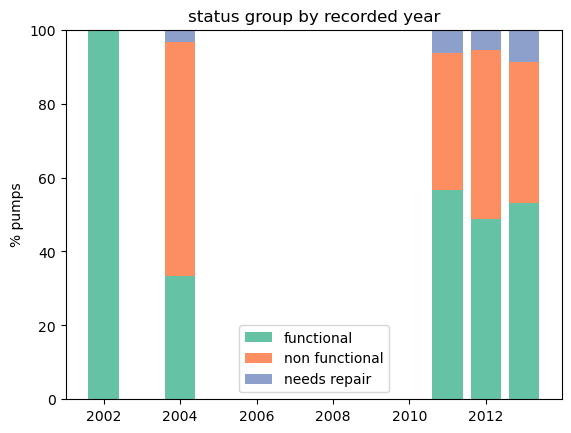

In [38]:
#plot status group by recorded year

fig, ax = plt.subplots()
labels = temp['recorded_year'].sort_values().unique()[1:]
ax.bar(labels, recorded['perc_functional'], label ='functional' ,  color = '#66c2a5')
ax.bar (labels, recorded['perc_non_functional'], label = 'non functional', bottom = recorded['perc_functional'] , color = '#fc8e62')
ax.bar(labels, recorded['perc_functional_needs_repair'], label = 'needs repair', bottom = recorded['perc_functional'] + recorded['perc_non_functional'], color = '#8da0cb')
ax.set_title('status group by recorded year')
ax.set_ylabel('% pumps')
plt.legend()
plt.show()

The majority data are focusing between 2011 to 2013. Which is have the most of the variuos status group data.

#### 3.2.2 Recorded month

In [39]:
#create 'recorded_year' feature
temp = All_data.copy()
temp['recorded_month'] = pd.DatetimeIndex(temp['date_recorded']).month

#check the distribution of 'status_group' for the 'recorded_year' feature
recorded = distribution_checker(temp ,'recorded_month')
recorded

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
recorded_month,,,,,
1,6354,10.7,41.1,46.2,12.7
2,12402,20.9,55.2,37.3,7.5
3,17936,30.2,61.7,33.3,5.0
4,3970,6.7,51.6,37.3,11.0
5,336,0.6,60.1,36.9,3.0
6,346,0.6,78.0,19.4,2.6
7,6928,11.7,50.2,41.9,7.9
8,3364,5.7,51.1,41.4,7.5
9,328,0.6,65.2,31.7,3.0


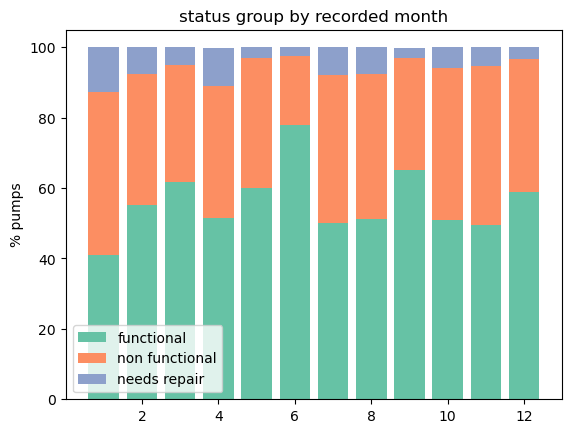

In [40]:
#plot status group by 'recorded_month'
fig, ax = plt.subplots()
labels = temp['recorded_month'].sort_values().unique()
ax.bar(labels, recorded['perc_functional'], label = 'functional' ,  color = '#66c2a5')
ax.bar (labels, recorded['perc_non_functional'], label = 'non functional', bottom = recorded['perc_functional'] , color = '#fc8e62')
ax.bar(labels, recorded['perc_functional_needs_repair'], label = 'needs repair', bottom = recorded['perc_functional'] + recorded['perc_non_functional'], color = '#8da0cb')
ax.set_title('status group by recorded month')
ax.set_ylabel('% pumps')
plt.legend()
plt.show()

The status of most pumps recorded is in February and March and far less in May and June. The data showing a trend that with less recorded month which will contain less needs repair pump.

It seems that the functionality rates of pumps vary across different months, though this observation could be influenced by the fewer data entries recorded during these periods.

In conclusion, we may replace construction month rather than construction year because it is containing a bit more detail. We can use weather condition to category all month into 4 weather condition.

In [41]:
All_data['month'] = pd.DatetimeIndex(All_data['date_recorded']).month

# season encoder
season_mapper = {1: 'Winter',2:'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',6: 'Summer', 
                 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11:'Autumn', 12:'Winter'}
#.p feature values to scale
All_data['season']=All_data['month'].replace(season_mapper)
All_data=All_data.drop('month', axis=1)

In [43]:
All_data

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,season
0,50785,318.685704,4/2/2013,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Spring
1,51630,318.685704,4/2/2013,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring
2,17168,318.685704,1/2/2013,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Winter
3,45559,318.685704,22/1/2013,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN,Winter
4,49871,500.000000,27/3/2013,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.000000,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,Spring
59396,27263,4700.000000,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,Spring
59397,37057,318.685704,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional,Spring
59398,31282,318.685704,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,Spring


### 3.3 funder

In [ ]:
cat_analysis.loc[['funder']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
funder,object,69743,2139,4507,6.1,Government Of Tanzania,11299,16.2


In [ ]:
funder = distribution_checker(All_data, 'funder')
funder = funder.sort_values('nr_pumps', ascending= False)
funder.head(10)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
funder,,,,,
Government Of Tanzania,9084.0,16.3,41.0,51.3,7.7
Danida,3114.0,5.6,55.0,39.9,5.1
Hesawa,2202.0,3.9,42.5,47.0,10.5
Rwssp,1374.0,2.5,58.6,33.5,7.9
World Bank,1349.0,2.4,40.4,52.4,7.2
Kkkt,1287.0,2.3,56.2,38.7,5.1
World Vision,1246.0,2.2,59.6,29.9,10.5
Unicef,1057.0,1.9,56.8,33.9,9.4
Tasaf,877.0,1.6,56.2,36.5,7.3


Funder has over 2000 unique categories. The Government of Tanzania is with 16% the most common funder.  Just by looking at the top 10 most common funders we can see the 'status_group' distribution differs. I therefore think 'funder' could be an interessting column to include in a model, but we have to find a suitable way to encode it without increasing the dimensionality of the dataframe too much. 

In [ ]:
All_data['funder'] = All_data['funder'].fillna(All_data['installer'].mode().to_list()[0])

In [ ]:
All_data['funder'].isna().sum()

0

### 3.4 installer


In [ ]:
cat_analysis.loc[['installer']]


,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
installer,object,69718,2410,4532,6.1,DWE,21751,31.2


In [ ]:
All_data['installer'].isna().sum()

4532

In [ ]:
#check the distribution of status groups for the 10 most frequent installer
installer = distribution_checker(All_data, 'installer')
installer = installer.sort_values('nr_pumps', ascending= False)
installer.head(10)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
installer,,,,,
DWE,17402.0,31.2,54.2,36.5,9.3
Government,1825.0,3.3,29.3,56.7,14.0
RWE,1206.0,2.2,25.2,63.4,11.4
Commu,1060.0,1.9,68.3,28.7,3.0
DANIDA,1050.0,1.9,51.6,40.5,7.9
KKKT,898.0,1.6,47.0,46.1,6.9
Hesawa,840.0,1.5,56.5,41.4,2.0
0,777.0,1.4,57.3,42.3,0.4
TCRS,707.0,1.3,41.0,53.0,5.9


Installer has like funder a very high cardinality. DWE is by far the most common installer. Again we see differences in the distribution of 'status_group' in the top 10 installers. Installer could be an interessting feature, but it has to be encoded properly to avoid increasing the dimensionality of the dataset.

In [ ]:
All_data['installer'].mode().to_list()[0]

'DWE'

In [ ]:
All_data['installer'] = All_data['installer'].fillna(All_data['installer'].mode().to_list()[0])

In [ ]:
All_data['installer'].isna().sum()

0

In [ ]:
min_val = installer['nr_pumps'].min()
max_val = installer['nr_pumps'].max()
installer['installer_share'] = (installer['nr_pumps'] - min_val) / (max_val - min_val)
installer_share = installer['installer_share'].to_dict()

All_data['installer'] = All_data['installer'].map(installer_share)
All_data['installer'] 
#print()

0        0.005057
1        1.000000
2        1.000000
3        0.001839
4        0.000862
           ...   
59395    0.034998
59396    0.000805
59397    1.000000
59398    0.000230
59399    0.006896
Name: installer, Length: 74250, dtype: float64

Installer will be replaced by grouped by number of pumps data, and the value will be normalized to show the share over all installer.

### 3.5 GPS height

In [ ]:
num_analysis.loc[['gps_height']]


,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
gps_height,int64,74250,0,0.0,2456,665.7,692.8,-90.0,0.0,364.0,1317.0,2777.0,0.0,25649,34.5


In [ ]:
All_data['gps_height']

0        1996
1        1569
2        1567
3         267
4        1260
         ... 
59395    1210
59396    1212
59397       0
59398       0
59399     191
Name: gps_height, Length: 74250, dtype: int64

/var/folders/zg/3w16yt6n5g9bvlyjkyzc5k3r0000gn/T/ipykernel_71906/1996353301.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['gps_height_zero'] = np.where(temp['gps_height']==0, 'yes', 'no')


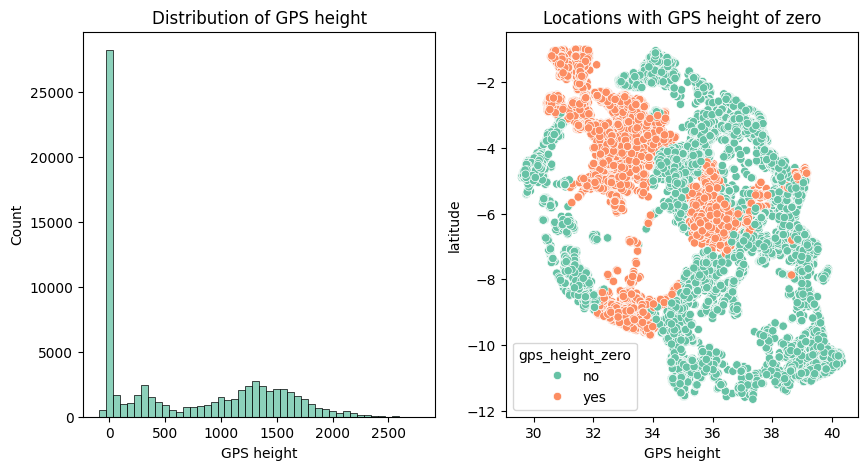

In [ ]:
fig, axes = plt.subplots(1, 2,  figsize=(10,5))

#plot distribution of gps height
sns.histplot( All_data[ 'gps_height'], color = '#66c2a5', ax=axes[0])
axes[0].set(title = 'Distribution of GPS height', xlabel = 'GPS height')

#plot locations where gps height is zero
temp = All_data[All_data['longitude']!=0]  #only include records where logitude isn't zero
temp['gps_height_zero'] = np.where(temp['gps_height']==0, 'yes', 'no')
sns.scatterplot(x= temp['longitude'], y = temp['latitude'], hue = temp['gps_height_zero'], palette='Set2', ax = axes[1])
axes[1].set(title = 'Locations with GPS height of zero', xlabel = 'GPS height')

plt.show()

Tanzania is not situated below sea level; therefore, any negative readings for GPS height are incorrect. Typically, the GPS altitude error margin is approximately ± 15 meters, which is accurate 95% of the time. During the remaining 5%, the altitude could register any value. It is unclear whether the GPS height refers to the water level height or the well location. What is evident, however, is that most places recording a GPS height of zero are not at sea level. From this, I infer that zero is often used to denote missing data in GPS height recordings.

The data did not represent any interest trend, so this time we can try to drop it and let's see how the result showing us. 

In [ ]:
All_data = All_data.drop(columns='gps_height')

In [ ]:
All_data.head(5)

,id,amount_tsh,date_recorded,funder,installer,longitude,latitude,wpt_name,num_private,basin,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,season
0,50785,318.685704,4/2/2013,Dmdd,0.005057,35.290799,-4.059696,Dinamu Secondary School,0,Internal,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Spring
1,51630,318.685704,4/2/2013,Government Of Tanzania,1.000000,36.656709,-3.309214,Kimnyak,0,Pangani,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring
2,17168,318.685704,1/2/2013,DWE,1.000000,34.767863,-5.004344,Puma Secondary,0,Internal,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Winter
3,45559,318.685704,22/1/2013,Finn Water,0.001839,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN,Winter
4,49871,500.000000,27/3/2013,Bruder,0.000862,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring


### 3.6 Longitude

In [ ]:
num_analysis.loc[['longitude']]

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
longitude,float64,74250,0,0.0,71870,34.1,6.6,0.0,33.1,34.9,37.2,40.3,0.0,2269,3.1


A longitude of zero does not exist for Tanzania. Missing values are imputed as zero.

In [ ]:
All_data = All_data.drop(columns='longitude')

In [ ]:
All_data.head(5)

,id,amount_tsh,date_recorded,funder,installer,latitude,wpt_name,num_private,basin,subvillage,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,season
0,50785,318.685704,4/2/2013,Dmdd,0.005057,-4.059696,Dinamu Secondary School,0,Internal,Magoma,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Spring
1,51630,318.685704,4/2/2013,Government Of Tanzania,1.000000,-3.309214,Kimnyak,0,Pangani,Kimnyak,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring
2,17168,318.685704,1/2/2013,DWE,1.000000,-5.004344,Puma Secondary,0,Internal,Msatu,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Winter
3,45559,318.685704,22/1/2013,Finn Water,0.001839,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN,Winter
4,49871,500.000000,27/3/2013,Bruder,0.000862,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring


### 3.7 Latitude

In [ ]:
num_analysis.loc[['latitude']]


,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
latitude,float64,74250,0,0.0,71869,-5.7,2.9,-11.6,-8.5,-5.0,-3.3,-0.0,-0.0,2269,3.1


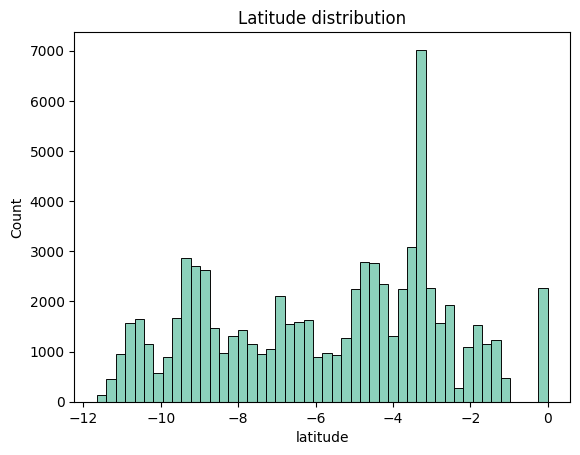

In [ ]:
#distribution of latitude
ax = sns.histplot( All_data[ 'latitude'], color = '#66c2a5')
ax.set(title = 'Latitude distribution')
plt.show()

From the data quality report the presense of zero is not immediately clear, but after plotting we can see that latitudes with a value of zero are indeed present. These represent missing values and need to be imputed properly.

In [ ]:
All_data = All_data.drop(columns='latitude')

In [ ]:
All_data.head(5)

,id,amount_tsh,date_recorded,funder,installer,wpt_name,num_private,basin,subvillage,region,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,season
0,50785,318.685704,4/2/2013,Dmdd,0.005057,Dinamu Secondary School,0,Internal,Magoma,Manyara,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Spring
1,51630,318.685704,4/2/2013,Government Of Tanzania,1.000000,Kimnyak,0,Pangani,Kimnyak,Arusha,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring
2,17168,318.685704,1/2/2013,DWE,1.000000,Puma Secondary,0,Internal,Msatu,Singida,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Winter
3,45559,318.685704,22/1/2013,Finn Water,0.001839,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN,Winter
4,49871,500.000000,27/3/2013,Bruder,0.000862,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring


### 3.8 Wpt Name

In [ ]:
cat_analysis.loc[['wpt_name']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
wpt_name,object,74248,45683,2,0.0,none,4440,6.0


In [ ]:
#check the distribution of status groups for the 10 most frequent namesb
name = distribution_checker(All_data, 'wpt_name')
name= name.sort_values('nr_pumps', ascending= False)
name.head(10)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
wpt_name,,,,,
none,3563.0,6.0,73.8,24.1,2.1
Shuleni,1748.0,2.9,49.1,42.7,8.2
Zahanati,830.0,1.4,51.8,38.8,9.4
Msikitini,535.0,0.9,49.2,42.6,8.2
Kanisani,323.0,0.5,48.0,45.5,6.5
Bombani,271.0,0.5,58.3,33.9,7.7
Sokoni,260.0,0.4,46.2,43.8,10.0
Ofisini,254.0,0.4,43.3,52.4,4.3
School,208.0,0.4,41.8,51.9,6.2


Waterpoint name has an extremely high cardinality. The most common name is 'None', indicating that the pump has no name. As expected, the name of the waterpump appears to have no relationship with the status of the pump. This is a feature that we can drop later.

In [ ]:
All_data = All_data.drop(columns='wpt_name')

In [ ]:
All_data.head(5)

,id,amount_tsh,date_recorded,funder,installer,num_private,basin,subvillage,region,region_code,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,season
0,50785,318.685704,4/2/2013,Dmdd,0.005057,0,Internal,Magoma,Manyara,21,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Spring
1,51630,318.685704,4/2/2013,Government Of Tanzania,1.000000,0,Pangani,Kimnyak,Arusha,2,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring
2,17168,318.685704,1/2/2013,DWE,1.000000,0,Internal,Msatu,Singida,13,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Winter
3,45559,318.685704,22/1/2013,Finn Water,0.001839,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN,Winter
4,49871,500.000000,27/3/2013,Bruder,0.000862,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring


### 3.9 Num private


In [ ]:
num_analysis.loc[['num_private']]

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
num_private,int64,74250,0,0.0,68,0.5,11.5,0.0,0.0,0.0,0.0,1776.0,0.0,73299,98.7



It is immediately clear that this feature will hold little information as 98.7% of the records consists of the value zero. This is a good candidate to drop from later analysis.

In [ ]:
All_data = All_data.drop(columns='num_private')

In [ ]:
All_data.head(5)

,id,amount_tsh,date_recorded,funder,installer,basin,subvillage,region,region_code,district_code,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,season
0,50785,318.685704,4/2/2013,Dmdd,0.005057,Internal,Magoma,Manyara,21,3,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Spring
1,51630,318.685704,4/2/2013,Government Of Tanzania,1.000000,Pangani,Kimnyak,Arusha,2,2,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring
2,17168,318.685704,1/2/2013,DWE,1.000000,Internal,Msatu,Singida,13,2,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,Winter
3,45559,318.685704,22/1/2013,Finn Water,0.001839,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN,Winter
4,49871,500.000000,27/3/2013,Bruder,0.000862,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,Spring


### 3.10 Basin

In [ ]:
cat_analysis.loc[['basin']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
basin,object,74250,9,0,0.0,Lake Victoria,12871,17.3


In [ ]:
basin = distribution_checker(All_data, 'basin')
basin = basin.sort_values('nr_pumps', ascending= False)
basin.head(20)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
basin,,,,,
Lake Victoria,10248.0,17.3,49.8,40.6,9.7
Pangani,8940.0,15.1,60.1,34.6,5.3
Rufiji,7976.0,13.4,63.5,31.0,5.5
Internal,7785.0,13.1,57.6,35.3,7.2
Lake Tanganyika,6432.0,10.8,48.3,40.2,11.5
Wami / Ruvu,5987.0,10.1,52.4,43.1,4.5
Lake Nyasa,5085.0,8.6,65.4,29.7,4.9
Ruvuma / Southern Coast,4493.0,7.6,37.2,55.6,7.3
Lake Rukwa,2454.0,4.1,40.7,48.2,11.0


The distribution of pumps over the different basins if fairly equal. We previously saw that certain regions have much more functional or non-functional pumps. It is therefore not surprising that certain basins also have more or less functional pumps. 

In [ ]:
tem_basin = pd.get_dummies(All_data['basin'],dtype='int_')
All_data = pd.concat([All_data, tem_basin], axis=1)


All_data = All_data.drop(columns='basin')
All_data

,id,amount_tsh,date_recorded,funder,installer,subvillage,region,region_code,district_code,lga,...,season,Internal,Lake Nyasa,Lake Rukwa,Lake Tanganyika,Lake Victoria,Pangani,Rufiji,Ruvuma / Southern Coast,Wami / Ruvu
0,50785,318.685704,4/2/2013,Dmdd,0.005057,Magoma,Manyara,21,3,Mbulu,...,Spring,1,0,0,0,0,0,0,0,0
1,51630,318.685704,4/2/2013,Government Of Tanzania,1.000000,Kimnyak,Arusha,2,2,Arusha Rural,...,Spring,0,0,0,0,0,1,0,0,0
2,17168,318.685704,1/2/2013,DWE,1.000000,Msatu,Singida,13,2,Singida Rural,...,Winter,1,0,0,0,0,0,0,0,0
3,45559,318.685704,22/1/2013,Finn Water,0.001839,Kipindimbi,Lindi,80,43,Liwale,...,Winter,0,0,0,0,0,0,0,1,0
4,49871,500.000000,27/3/2013,Bruder,0.000862,Losonga,Ruvuma,10,3,Mbinga,...,Spring,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.000000,2013-05-03,Germany Republi,0.034998,Kiduruni,Kilimanjaro,3,5,Hai,...,Spring,0,0,0,0,0,1,0,0,0
59396,27263,4700.000000,2011-05-07,Cefa-njombe,0.000805,Igumbilo,Iringa,11,4,Njombe,...,Spring,0,0,0,0,0,0,1,0,0
59397,37057,318.685704,2011-04-11,DWE,1.000000,Madungulu,Mbeya,12,7,Mbarali,...,Spring,0,0,0,0,0,0,1,0,0
59398,31282,318.685704,2011-03-08,Malec,0.000230,Mwinyi,Dodoma,1,4,Chamwino,...,Spring,0,0,0,0,0,0,1,0,0


### 3.11 Region

In [ ]:
cat_analysis.loc[['region']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
region,object,74250,21,0,0.0,Iringa,6599,8.9


In [ ]:
region = distribution_checker(All_data, 'region')
region = region.sort_values('nr_pumps', ascending= False)
region.head(20)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
region,,,,,
Iringa,5294.0,8.9,78.2,19.5,2.3
Shinyanga,4982.0,8.4,56.0,31.3,12.7
Mbeya,4639.0,7.8,50.0,39.1,10.9
Kilimanjaro,4379.0,7.4,60.3,32.4,7.4
Morogoro,4006.0,6.7,52.9,39.6,7.5
Arusha,3350.0,5.6,68.5,26.3,5.2
Kagera,3316.0,5.6,52.1,38.8,9.2
Mwanza,3102.0,5.2,48.4,45.7,5.9
Kigoma,2816.0,4.7,48.4,30.2,21.4


Tanzania has 21 different regions and from the table above we can already see that certain regions have a much higher proportion of functional pumps than other regions. The location of the pumps is therefore relevant.

### 3.12 Region code (need to do nor)

In [ ]:
num_analysis.loc[['region_code']]

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
region_code,int64,74250,0,0.0,27,15.3,17.5,1.0,5.0,12.0,17.0,99.0,11.0,6608,8.9


In [ ]:
#group region_codes by region
region_code = All_data.groupby(['region','region_code',])['id'].count().reset_index()
region_code.head(10)

,region,region_code,id
0,Arusha,2,3709
1,Arusha,24,402
2,Dar es Salaam,7,1020
3,Dodoma,1,2779
4,Iringa,11,6599
5,Kagera,18,4174
6,Kigoma,16,3533
7,Kilimanjaro,3,5494
8,Lindi,8,375
9,Lindi,18,9


In [ ]:
#check distribution of status group by region code
region_code = distribution_checker(All_data, 'region_code')
region_code = region_code.sort_values('nr_pumps', ascending= False)
region_code.head(20)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
region_code,,,,,
11,5300.0,8.9,78.2,19.5,2.3
17,5011.0,8.4,56.0,31.3,12.7
12,4639.0,7.8,50.0,39.1,10.9
3,4379.0,7.4,60.3,32.4,7.4
5,4040.0,6.8,53.1,39.4,7.4
18,3324.0,5.6,52.0,38.8,9.1
19,3047.0,5.1,48.2,46.0,5.8
2,3024.0,5.1,65.4,28.8,5.8
16,2816.0,4.7,48.4,30.2,21.4


Tanzania has 21 different regions, but 27 different region_codes. This means that the regio_code feature contains slightly more information that the region feature. It must be said that some of the region_code categories contain only a few pumps. The region Arusha has 68.5% functional pumps. When we look at the region_codes within Arusha, we see that this percentage varies between 65 and 97%. This is a big and interessting difference!

### 3.13 District code

In [ ]:
num_analysis.loc[['district_code']]

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
district_code,int64,74250,0,0.0,20,5.6,9.6,0.0,2.0,3.0,5.0,80.0,1.0,15299,20.6


In [ ]:
#group region_codes by region
district_code = All_data.groupby([  'region', 'district_code',])['id'].count().reset_index()
district_code.head(10)

,region,district_code,id
0,Arusha,1,226
1,Arusha,2,1460
2,Arusha,3,143
3,Arusha,5,245
4,Arusha,6,391
5,Arusha,7,1244
6,Arusha,30,402
7,Dar es Salaam,1,121
8,Dar es Salaam,2,633
9,Dar es Salaam,3,266


Tanzania has 20 different district numbers, but it appears that these districts are relevant in the region context. So both Arusha and Dar es Salaam have a district 1. It might be interesting to create a region-district feature to capture this information.

### 3.14 Lga

In [ ]:
cat_analysis.loc[['lga']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
lga,object,74250,125,0,0.0,Njombe,3128,4.2


In [ ]:
#group lga by region
lga = All_data.groupby([  'region', 'lga',])['id'].count().reset_index()
lga.head(10)

,region,lga,id
0,Arusha,Arusha Rural,1521
1,Arusha,Arusha Urban,82
2,Arusha,Karatu,402
3,Arusha,Longido,391
4,Arusha,Meru,1244
5,Arusha,Monduli,226
6,Arusha,Ngorongoro,245
7,Dar es Salaam,Ilala,633
8,Dar es Salaam,Kinondoni,121
9,Dar es Salaam,Temeke,266


A region consists of different lga's. There are 125 different lga's, which is a bit too much to encode in a model, but it could be an useful feature for imputing missing geospatial data.

### 3.15 Ward

In [ ]:
cat_analysis.loc[['ward']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
ward,object,74250,2098,0,0.0,Igosi,386,0.5


In [ ]:
#group ward by lga
ward = All_data.groupby([  'lga', 'ward'])['id'].count().reset_index()
ward.head(10)

,lga,ward,id
0,Arusha Rural,Bangata,43
1,Arusha Rural,Bwawani,46
2,Arusha Rural,Ilkiding'a,104
3,Arusha Rural,Kimnyaki,93
4,Arusha Rural,Kiranyi,139
5,Arusha Rural,Kisongo,37
6,Arusha Rural,Mateves,28
7,Arusha Rural,Mlangarini,111
8,Arusha Rural,Moivo,52
9,Arusha Rural,Moshono,57


A lga can be further divided into different wards. A total of 2098 wards can be found in the dataset. Because of the high cardinality we cannot use this feature in a model, but it is useful for imputing purposes.

### 3.16 Subvillage

In [ ]:
cat_analysis.loc[['subvillage']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
subvillage,object,73780,21425,470,0.6,Shuleni,646,0.9


In [ ]:
#group ward by lga
village= All_data.groupby(['lga', 'ward', 'subvillage'])['id'].count().reset_index()
village.head(10)

,lga,ward,subvillage,id
0,Arusha Rural,Bangata,Engikaleti,23
1,Arusha Rural,Bangata,Gwasei,2
2,Arusha Rural,Bangata,Kwaniche,5
3,Arusha Rural,Bangata,Lobolosi,1
4,Arusha Rural,Bangata,Melenyi,1
5,Arusha Rural,Bangata,Ndukenyi,2
6,Arusha Rural,Bangata,Ngwasei,3
7,Arusha Rural,Bangata,Sanganani,5
8,Arusha Rural,Bangata,Sangananu,1
9,Arusha Rural,Bwawani,Buluga,2


Wards can be further divided into subvillages. The dataset contains over 20.000 subvillage. Most subvillages contain only 1 or a few pumps. This feature can be useful for imputing missing geospatial data.


#### This part is for conditional data handling, it will adding different dataframe into ex_data_list for further experiment

In [ ]:
All_data.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,50785,0.0,4/2/2013,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN
1,51630,0.0,4/2/2013,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN


In [ ]:
con_1 = All_data.drop(columns='subvillage')
ex_data_list.append(con_1)

con_2 = All_data.drop(['lga', 'ward','district_code'], axis=1)
ex_data_list.append(con_2)

### 3.17 population

In [11]:
num_analysis.loc[['population']]

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
population,int64,74250,0,0.0,1128,180.8,471.1,0.0,0.0,25.0,215.0,30500.0,0.0,26834,36.1


In [12]:
# Count the number of zeros and ones in the 'population' data
count_zero = (All_data['population']==0).sum()
count_one = (All_data['population']==1).sum()
count_zero, count_one

(26834, 8782)

In [13]:
# Replace the zeros and ones with median
All_data['population'] = All_data['population'].replace(0,All_data['population'].median())
All_data['population'] = All_data['population'].replace(1,All_data['population'].median())

In [14]:
# Make the All_data_2 and replace the zeros and ones with mean in All_data_2
All_data_2 = All_data.copy()
All_data_2['population'] = All_data_2['population'].replace(0,All_data_2['population'].mean())
All_data_2['population'] = All_data_2['population'].replace(1,All_data_2['population'].mean())

In [15]:
# Use Z-score normalization
All_data['population'] = (All_data['population']-All_data['population'].mean())/(All_data['population'].std())
All_data_2['population'] = (All_data_2['population']-All_data_2['population'].mean())/(All_data_2['population'].std())

In [16]:
ex_data_list.append(All_data_2)

There are considerable amount of zeros(36.1%) and ones(11.8%) in the data. Therefore, zeros and ones in the 'population' data are replaced with median in All_data. All_data_2 is created for the conditional data handling and zeros and ones data are replaced with mean. And it is added to ex_data_list. 

### 3.18 public_meeting

In [17]:
cat_analysis.loc[['public_meeting']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
public_meeting,object,70095,2,4155,5.6,True,63749,90.9


In [18]:
# Replace True with 1 and False with 0
All_data['public_meeting'] = All_data['public_meeting'].replace(True, 1)
All_data['public_meeting'] = All_data['public_meeting'].replace(False, 0)

In [19]:
All_data['public_meeting'].mode()

0    1.0
Name: public_meeting, dtype: float64

In [20]:
# Replace the missing values with 1
All_data['public_meeting'] = All_data['public_meeting'].replace(np.nan, 1)

Missing values in 'public meeting' data are replaced with mode which is 1(True). 

### 3.19 recorded_by

In [21]:
All_data['recorded_by'].unique()

array(['GeoData Consultants Ltd'], dtype=object)

The 'recorded_by' column has only one attribute which is GeoData Consultants Ltd. So we assumed that it is not an important data and decided to drop this column.

In [22]:
All_data = All_data.drop(['recorded_by'], axis=1)

### 3.20 scheme_name

In [23]:
cat_analysis.loc[['scheme_name']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
scheme_name,object,38198,2867,36052,48.6,K,858,2.2


In [24]:
All_data['scheme_name'].isna().sum()

36052

In [25]:
# check the distribution of status group for scheme_name
s_name = distribution_checker(All_data, 'scheme_name')
s_name = s_name.sort_values('nr_pumps', ascending=False)
s_name.head(10)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
scheme_name,,,,,
K,682,2.2,55.1,28.0,16.9
Borehole,546,1.8,37.4,57.9,4.8
Chalinze wate,405,1.3,85.9,14.1,0.0
M,400,1.3,49.2,36.8,14.0
DANIDA,379,1.2,52.5,43.0,4.5
Government,320,1.0,46.9,43.1,10.0
Ngana water supplied scheme,270,0.9,25.9,72.6,1.5
wanging'ombe water supply s,261,0.9,63.2,18.8,18.0
wanging'ombe supply scheme,234,0.8,62.4,27.4,10.3


The missing value is 48.5% and there are 2867 unique values in the data. Also the scheme name seems to have no relationship with the status of the pump. So we decided to drop this column.

In [26]:
All_data = All_data.drop(['scheme_name'], axis=1)

### 3.21 permit

In [27]:
cat_analysis.loc[['permit']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
permit,object,70457,2,3793,5.1,True,48606,69.0


In [28]:
# Replace True with 1 and False with 0
All_data['permit'] = All_data['permit'].replace(True, 1)
All_data['permit'] = All_data['permit'].replace(False, 0)

In [29]:
All_data['permit'].mode()

0    1.0
Name: permit, dtype: float64

In [30]:
All_data['permit'] = All_data['permit'].replace(np.nan, 1)

Missing values in 'permit' data are replaced with mode which is 1(True). 

### 3.22 construction_year

In [31]:
num_analysis.loc[['construction_year']]

,Data Type,Count,Missing Values,Missing in %,Unique Values,Mean,Standard Deviation,Minimum,1st Quartile,Median,3rd Quartile,Maximum,Mode,Mode freq,Mode in %
construction_year,int64,74250,0,0.0,55,1298.5,952.3,0.0,0.0,1986.0,2004.0,2013.0,0.0,25969,35.0


In [32]:
# Replace the missing data with mean in All_data and median in All_data_3
All_data['construction_year'] = All_data['construction_year'].replace(0, All_data['construction_year'].mean())

All_data_3 = All_data.copy()
All_data_3['construction_year'] = All_data_3['construction_year'].replace(0, All_data_3['construction_year'].median())

# Divide the construction year into 6 categories 
def categorize_year(year):
    if 1960 <= year <1970:
        return '60s'
    elif 1970 <= year <1980:
        return '70s'
    elif 1980 <= year <1990:
        return'80s'
    elif 1990 <= year <2000:
        return'90s'
    elif 2000 <= year <2010:
        return '00s'
    elif 2010 <= year <2020:
        return '10s'
    
All_data['construction_year'] = All_data['construction_year'].apply(categorize_year)
All_data_3['construction_year'] = All_data_3['construction_year'].apply(categorize_year)

In [33]:
# Check the distribution for construction year 
year = distribution_checker(All_data, 'construction_year')
year_order = ['60s', '70s', '80s', '90s', '00s', '10s']
year = year.loc[year_order]
year.head(10)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
construction_year,,,,,
60s,538,1.4,29.0,63.2,7.8
70s,4406,11.4,31.9,60.2,7.9
80s,5578,14.4,39.8,52.6,7.6
90s,7678,19.8,53.9,39.3,6.7
00s,15330,39.6,65.2,28.5,6.4
10s,5161,13.3,73.5,22.2,4.3


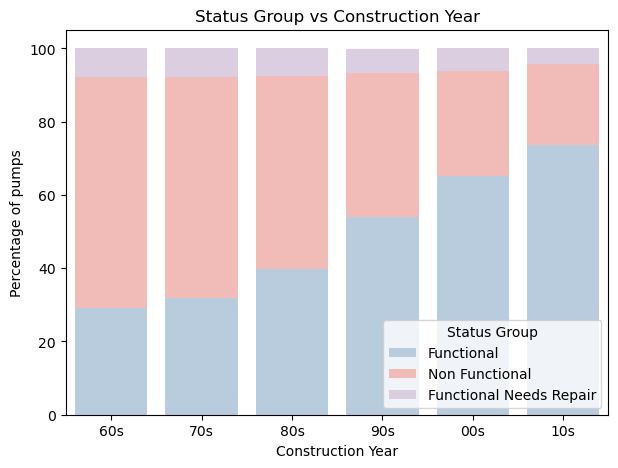

In [34]:
# Draw the bar chart for construction year
plt.figure(figsize=(7,5))
sns.barplot(x=year.index, y='perc_functional', data=year, color='#b3cde3', label='Functional')
sns.barplot(x=year.index, y='perc_non_functional', data=year, color='#fbb4ae', bottom=year['perc_functional'], label='Non Functional')
sns.barplot(x=year.index, y='perc_functional_needs_repair', data=year, color='#decbe4', bottom=year['perc_functional'] + year['perc_non_functional'], label='Functional Needs Repair')

plt.title('Status Group vs Construction Year')
plt.xlabel('Construction Year')
plt.ylabel('Percentage of pumps')
plt.legend(title='Status Group', loc='lower right')
plt.show()

The percentage of functional pump is higher if it is more recent pump. Therefore, we think the construction year data is important for deciding the functional status of the pump.

In [35]:
# Do one hot encoding
construct_year = pd.get_dummies(All_data['construction_year'], dtype='int_')
All_data = pd.concat([All_data, construct_year],axis=1)

All_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,00s,10s,60s,70s,80s,90s
0,50785,0.0,4/2/2013,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,0.275084,1.0,Parastatal,1.0,10s,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,0,1,0,0,0,0
1,51630,0.0,4/2/2013,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,0.230085,1.0,VWC,1.0,00s,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,1,0,0,0,0,0
2,17168,0.0,1/2/2013,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,0.658646,1.0,VWC,1.0,10s,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,NaN,0,1,0,0,0,0
3,45559,0.0,22/1/2013,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,0.122945,1.0,VWC,1.0,80s,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,NaN,0,0,0,0,1,0
4,49871,500.0,27/3/2013,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,-0.284188,1.0,Water Board,1.0,00s,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,1,0,0,0,0,0


In [36]:
# Do one hot encoding
ohe_data = pd.get_dummies(All_data['construction_year'], dtype='int_')
All_data_3 = pd.concat([All_data_3, ohe_data],axis=1)

# Add the All_data_3 to ex_data_list for conditional data handling
ex_data_list.append(All_data_3)

### 3.23 extraction_type_group

In [37]:
cat_analysis.loc[['extraction_type_group']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
extraction_type_group,object,74250,13,0,0.0,gravity,33263,44.8


In [38]:
# Check the distribution of status group for extraction type group
ext_type_group = distribution_checker(All_data, 'extraction_type_group')
ext_type_group = ext_type_group.sort_values('nr_pumps', ascending=False)
ext_type_group.head(13)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
extraction_type_group,,,,,
gravity,26780,45.1,59.9,30.0,10.1
nira/tanira,8154,13.7,66.5,25.7,7.9
other,6430,10.8,16.0,80.8,3.2
submersible,6179,10.4,53.9,42.0,4.1
swn 80,3670,6.2,56.9,37.3,5.8
mono,2865,4.8,37.8,57.7,4.5
india mark ii,2400,4.0,60.3,36.4,3.3
afridev,1770,3.0,67.8,29.8,2.4
rope pump,451,0.8,65.0,31.3,3.8


### 3.24 extraction_type

In [39]:
cat_analysis.loc[['extraction_type']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
extraction_type,object,74250,18,0,0.0,gravity,33263,44.8


In [40]:
# Check the distribution of status group for extraction type 
extract_type = distribution_checker(All_data, 'extraction_type')
extract_type = extract_type.sort_values('nr_pumps', ascending=False)
extract_type.head(13)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
extraction_type,,,,,
gravity,26780,45.1,59.9,30.0,10.1
nira/tanira,8154,13.7,66.5,25.7,7.9
other,6430,10.8,16.0,80.8,3.2
submersible,4764,8.0,55.1,40.1,4.8
swn 80,3670,6.2,56.9,37.3,5.8
mono,2865,4.8,37.8,57.7,4.5
india mark ii,2400,4.0,60.3,36.4,3.3
afridev,1770,3.0,67.8,29.8,2.4
ksb,1415,2.4,49.7,48.5,1.8


We can know that extraction type group and extraction type are very similar by checking the distribution of the data. Therefore we drop the extraction type. Because it is too detailed(more unique values).

In [41]:
All_data = All_data.drop(['extraction_type'], axis=1)

### 3.25 extraction_type_class

In [42]:
cat_analysis.loc[['extraction_type_class']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
extraction_type_class,object,74250,7,0,0.0,gravity,33263,44.8


Text(0.5, 1.0, 'Functional status for Extraction Type Class')

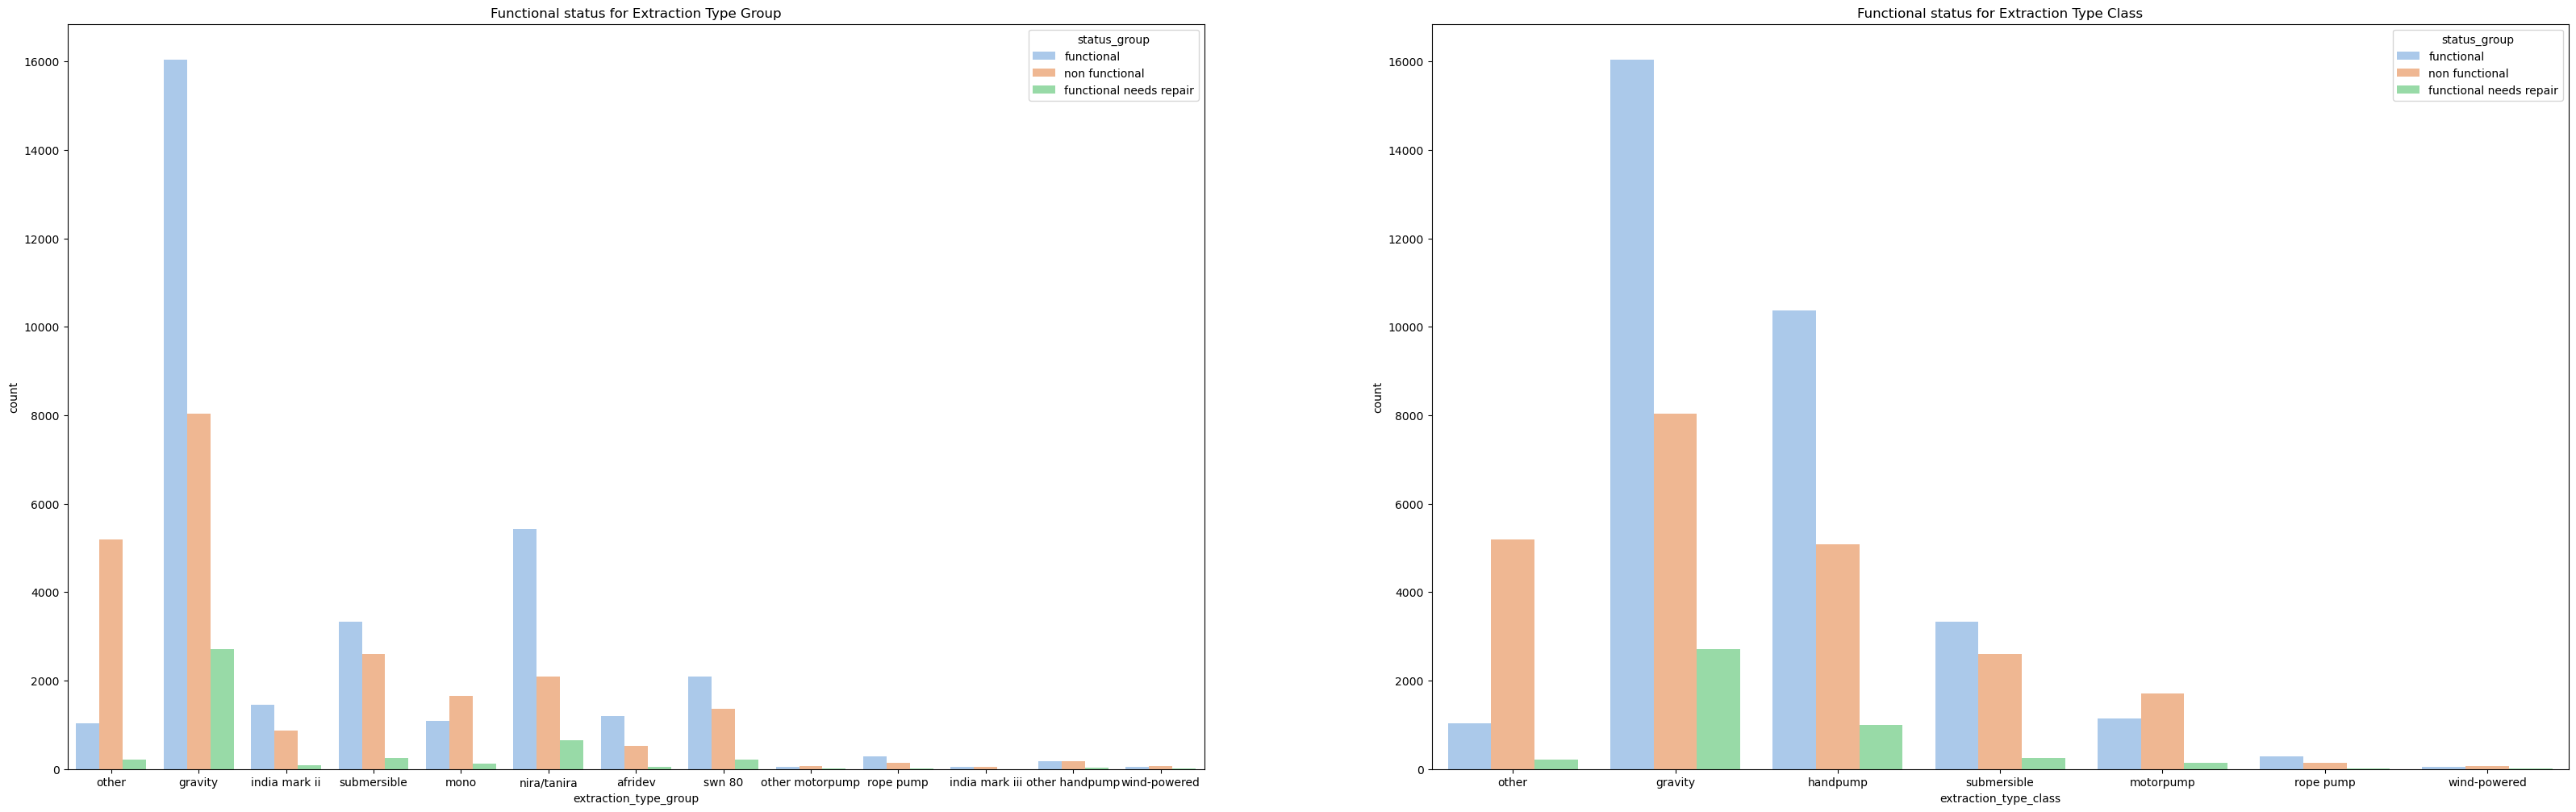

In [43]:
# Draw the countplot for extraction type group and extraction type class
fig, axes = plt.subplots(1, 2, figsize=(40,12))

sns.countplot(x='extraction_type_group', hue='status_group', palette='pastel', data=All_data, ax=axes[0])
axes[0].set_title('Functional status for Extraction Type Group')

sns.countplot(x='extraction_type_class', hue='status_group', palette='pastel', data=All_data, ax=axes[1])
axes[1].set_title('Functional status for Extraction Type Class')


In [44]:
# Do one hot encoding for extraction type group
type_group = pd.get_dummies(All_data, columns=['extraction_type_group'])
All_data = pd.concat([All_data, type_group],axis=1)

In [45]:
# Do one hot encoding for extraction type class
ext_type_class = pd.get_dummies(All_data, columns=['extraction_type_class'])
All_data = pd.concat([All_data, ext_type_class],axis=1)

Extraction type class is more broader than extraction type group. Therefore we decided to drop either extraction type class or extraction type group to know which is better for the modelling.

In [ ]:
con_3 = All_data.drop(columns='extraction_type')
ex_data_list.append(con_3)

con_4 = All_data.drop(columns='extraction_type_class')
ex_data_list.append(con_4)

### 3.26 scheme_management

In [46]:
cat_analysis.loc[['scheme_management']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
scheme_management,object,69403,11,4847,6.5,VWC,45917,66.2


In [47]:
All_data['scheme_management'].isna().sum()

scheme_management    4847
scheme_management    4847
scheme_management    4847
scheme_management    4847
dtype: int64

In [48]:
# Fill Nan with 'Unknown'
All_data = All_data.fillna({'scheme_management': 'Unknown'})

In [49]:
All_data['scheme_management'].isna().sum()

scheme_management    0
scheme_management    0
scheme_management    0
scheme_management    0
dtype: int64

In [50]:
# Do one hot encoding
tem_scheme = pd.get_dummies(All_data['scheme_management'],dtype='int_')
All_data = pd.concat([All_data, tem_scheme], axis=1)

### 3.27 management

In [51]:
cat_analysis.loc[['management']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
management,object,74250,12,0,0.0,vwc,50624,68.2


In [52]:
All_data['management'].isna().sum()

management    0
management    0
management    0
management    0
dtype: int64

In [53]:
# Do one hot encoding
tem_management = pd.get_dummies(All_data['management'],dtype='int_')
All_data = pd.concat([All_data, tem_management], axis=1)

### 3.27 management_group

In [54]:
cat_analysis.loc[['management_group']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
management_group,object,74250,5,0,0.0,user-group,65538,88.3


In [55]:
All_data['management_group'].isna().sum()

management_group    0
management_group    0
management_group    0
management_group    0
dtype: int64

In [56]:
# Do one hot encoding
tem_management_group = pd.get_dummies(All_data['management_group'],dtype='int_')
All_data = pd.concat([All_data, tem_management_group], axis=1)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

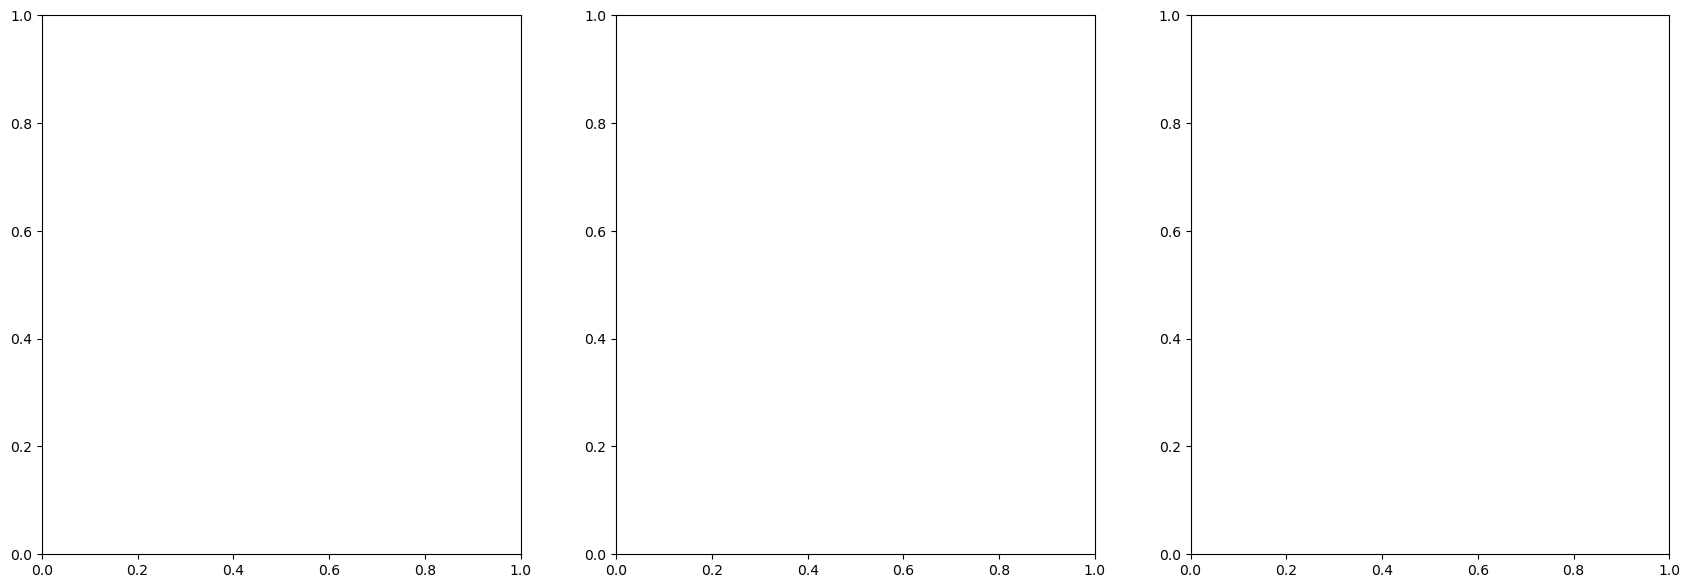

In [57]:
# Visualize these three features vs Status Group
fig, axes = plt.subplots(1, 3, figsize=(21, 7))  # 1 row, 3 columns

# First plot for Scheme Management vs Status Group
sns.countplot(x='scheme_management', hue='status_group', data=All_data, ax=axes[0])
axes[0].set_title('Distribution of Scheme Management by Status Group')
axes[0].tick_params(axis='x', rotation=45)

# Second plot for Management vs Status Group
sns.countplot(x='management', hue='status_group', data=All_data, ax=axes[1])
axes[1].set_title('Distribution of Management by Status Group')
axes[1].tick_params(axis='x', rotation=45)

# Third plot for Management Group vs Status Group
sns.countplot(x='management_group', hue='status_group', data=All_data, ax=axes[2])
axes[2].set_title('Distribution of Management Group by Status Group')
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

In [58]:
# Creating Crosstabs: Scheme Management vs Management
ct_scheme_management = pd.crosstab(All_data['scheme_management'], All_data['management'])

# Creating Crosstabs：Management vs Management Group
ct_management_mgmtgroup = pd.crosstab(All_data['management'], All_data['management_group'])

# Creating Crosstabs：Management Group vs Scheme Management
ct_mgmtgroup_scheme = pd.crosstab(All_data['management_group'], All_data['scheme_management'])

ValueError: 2

In [ ]:
# Normalized Crosstab
ct_scheme_management_normalized = ct_scheme_management.div(ct_scheme_management.sum(axis=1), axis=0)
ct_management_mgmtgroup_normalized = ct_management_mgmtgroup.div(ct_management_mgmtgroup.sum(axis=1), axis=0)
ct_mgmtgroup_scheme_normalized = ct_mgmtgroup_scheme.div(ct_mgmtgroup_scheme.sum(axis=1), axis=0)

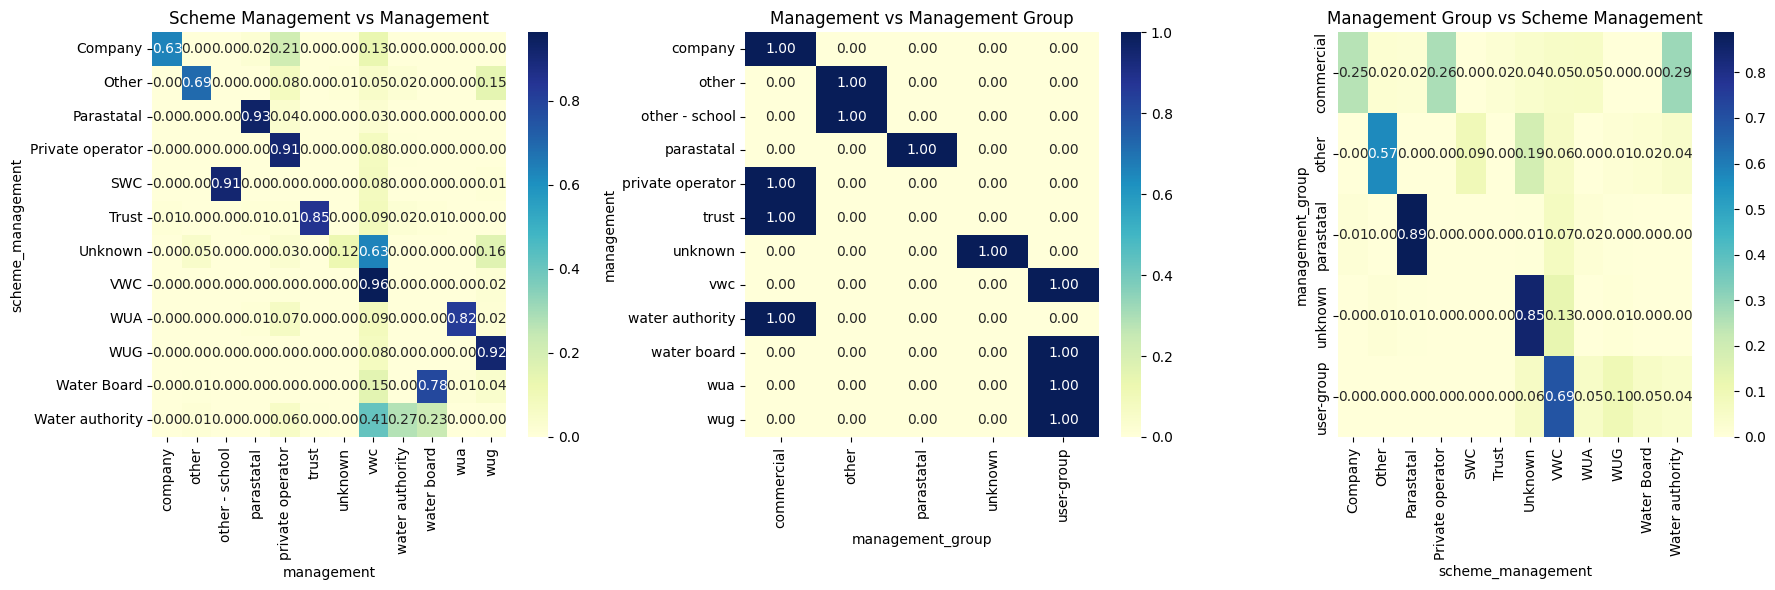

In [ ]:
# Draw the heatmap
# Adjust the total size as needed
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  

# Plot the first heatmap
sns.heatmap(ct_scheme_management_normalized, annot=True, cmap="YlGnBu", fmt=".2f", ax=axes[0])
axes[0].set_title('Scheme Management vs Management')

# Plot the second heatmap
sns.heatmap(ct_management_mgmtgroup_normalized, annot=True, cmap="YlGnBu", fmt=".2f", ax=axes[1])
axes[1].set_title('Management vs Management Group')

# Plot the third heatmap
sns.heatmap(ct_mgmtgroup_scheme_normalized, annot=True, cmap="YlGnBu", fmt=".2f", ax=axes[2])
axes[2].set_title('Management Group vs Scheme Management')

# Adjust layout
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

Because the relationship between **Management** and **Management Group** is very significant (almost a one-to-one correspondence), this suggests that at least one of the two variables is redundant because one variable almost perfectly predicts the value of the other.

To make sure which feature should be deleted, we need conditional data handling. This part is for conditional data handling


In [ ]:
con_5 = All_data.drop(columns='scheme_management')
ex_data_list.append(con_5)

con_6 = All_data.drop(columns='management')
ex_data_list.append(con_6)

con_7 = All_data.drop(columns='management_group')
ex_data_list.append(con_7)

### 3.28 payment


In [ ]:
cat_analysis.loc[['payment']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
payment,object,74250,7,0,0.0,never pay,31712,42.7


In [ ]:
print(All_data['payment'].value_counts())

payment
never pay                31712
pay per bucket           11266
pay monthly              10397
unknown                  10149
pay when scheme fails     4842
pay annually              4570
other                     1314
Name: count, dtype: int64


### 3.29 payment_type

In [ ]:
cat_analysis.loc[['payment_type']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
payment_type,object,74250,7,0,0.0,never pay,31712,42.7


In [ ]:
print(All_data['payment_type'].value_counts())

payment_type
never pay     31712
per bucket    11266
monthly       10397
unknown       10149
on failure     4842
annually       4570
other          1314
Name: count, dtype: int64


In [ ]:
# Map 'payment' values to 'payment_type' values
replacement_map = {
    'pay per bucket': 'per bucket',
    'pay monthly': 'monthly',
    'pay annually': 'annually',
    'never pay': 'never pay',
    'unknown': 'unknown',
    'pay when scheme fails': 'on failure',
    'other': 'other'
}

All_data['payment_standardized'] = All_data['payment'].replace(replacement_map)

In [ ]:
# Check if the standardized payment column is the same as payment_type
All_data['comparison'] = All_data['payment_standardized'] == All_data['payment_type']
all_identical = All_data['comparison'].all()

print(f"All values identical: {all_identical}")

All values identical: True


**payment** and **payment_type** have the same values, so drop one of them. Here we drop the **payment** column.

In [ ]:
 # Drop the original 'payment' column
All_data = All_data.drop(['payment'], axis=1)
All_data = All_data.drop(['payment_standardized'], axis=1)
All_data = All_data.drop(['comparison'], axis=1)

In [ ]:
# One hot encoding
All_data = pd.get_dummies(All_data, columns=['payment_type'], dtype='int_')

KeyError: "None of [Index(['payment_type'], dtype='object')] are in the [columns]"

In [ ]:
print(All_data.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'water_quality', 'quality_group',
       'quantity', 'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group', 'Company',
       'Other', 'Parastatal', 'Private operator', 'SWC', 'Trust', 'Unknown',
       'VWC', 'WUA', 'WUG', 'Water Board', 'Water authority', 'company',
       'other', 'other - school', 'parastatal', 'private operator', 'trust',
       'unknown', 'vwc', 'water authority', 'water board', 'wua', 'wug',
       'commercial', 'other', 'parasta

In [ ]:
# check the percentage of '0's
result_df = zero_percentage_table(All_data, ['payment_type_annually', 'payment_type_monthly', 'payment_type_never pay', 'payment_type_on failure', 'payment_type_other', 'payment_type_per bucket', 'payment_type_unknown'])
display(result_df)

,Column,Percentage of 0s
0,payment_type_annually,93.85%
1,payment_type_monthly,86.00%
2,payment_type_never pay,57.29%
3,payment_type_on failure,93.48%
4,payment_type_other,98.23%
5,payment_type_per bucket,84.83%
6,payment_type_unknown,86.33%


In [ ]:
# Drop the 'payment_type_other', since it has too many '0's
All_data = All_data.drop(['payment_type_other'], axis=1)

### 3.30 water_quality

In [ ]:
cat_analysis.loc[['water_quality']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
water_quality,object,74250,8,0,0.0,soft,63505,85.5


In [ ]:
print(All_data['water_quality'].value_counts())

water_quality
soft                  63505
salty                  6082
unknown                2345
milky                  1005
coloured                623
salty abandoned         423
fluoride                244
fluoride abandoned       23
Name: count, dtype: int64


### 3.31 quality_group

In [ ]:
cat_analysis.loc[['quality_group']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
quality_group,object,74250,6,0,0.0,good,63505,85.5


In [ ]:
print(All_data['quality_group'].value_counts())

quality_group
good        63505
salty        6505
unknown      2345
milky        1005
colored       623
fluoride      267
Name: count, dtype: int64


In [ ]:
# Check mapping from water_quality to quality_group
mapping_check = All_data.groupby(['water_quality', 'quality_group']).size().reset_index(name='Count')
print(mapping_check)

        water_quality quality_group  Count
0            coloured       colored    623
1            fluoride      fluoride    244
2  fluoride abandoned      fluoride     23
3               milky         milky   1005
4               salty         salty   6082
5     salty abandoned         salty    423
6                soft          good  63505
7             unknown       unknown   2345


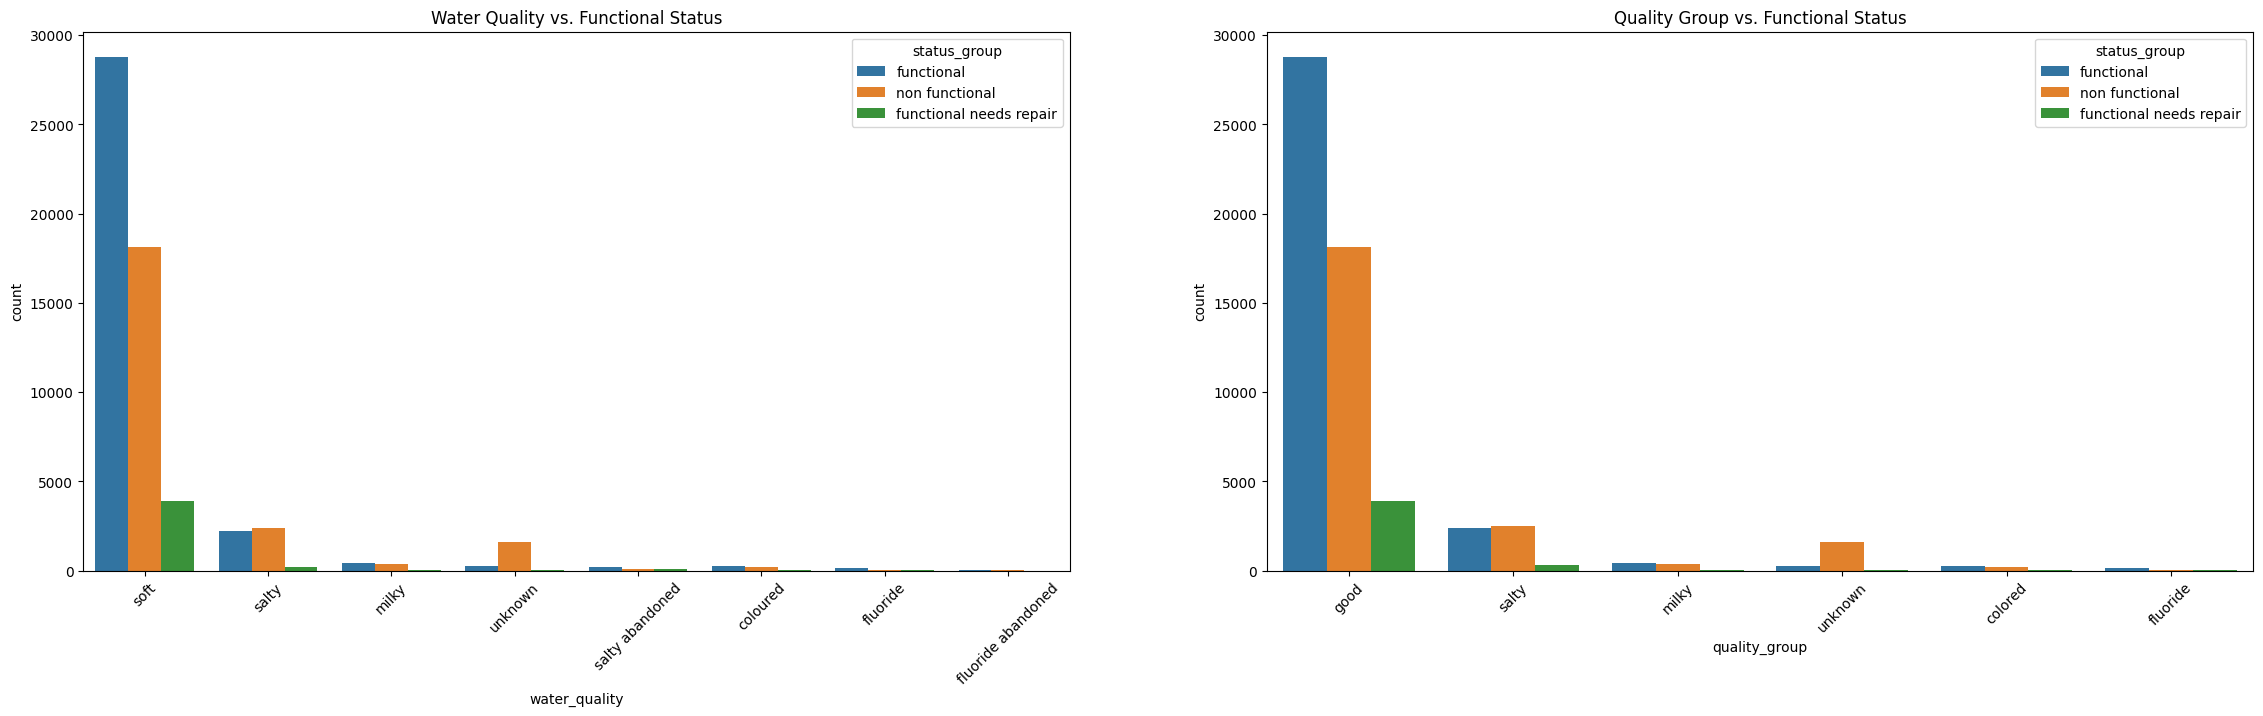

In [ ]:
subset = All_data[['water_quality', 'quality_group', 'status_group']]
plt.figure(figsize=(28, 7)) 

# Visualize water_quality vs status_group
plt.subplot(1, 2, 1)  
sns.countplot(data=subset, x='water_quality', hue='status_group')
plt.title('Water Quality vs. Functional Status')
plt.xticks(rotation=45)

# Visualize quality_group vs status_group
plt.subplot(1, 2, 2)  
sns.countplot(data=subset, x='quality_group', hue='status_group')
plt.title('Quality Group vs. Functional Status')
plt.xticks(rotation=45)

plt.show()


In this figure, although **water_quality** provides more details, the information of **quality_group** is enough to reflect the impact of water quality on functional status in most cases. Therefore, keeping **quality_group** may be a more reasonable choice. This can simplify the dataset while maintaining important information about the functional status of water points.

In [ ]:
# Drop the 'water_quality' colunm
All_data = All_data.drop(['water_quality'], axis=1)

In [ ]:
# One hot encoding
All_data = pd.get_dummies(All_data, columns=['quality_group'], dtype='int_')

In [ ]:
# check the percentage of '0's
result_df = zero_percentage_table(All_data, ['quality_group_colored', 'quality_group_fluoride', 'quality_group_good', 'quality_group_milky', 'quality_group_salty', 'quality_group_unknown'])
display(result_df)

,Column,Percentage of 0s
0,quality_group_colored,99.16%
1,quality_group_fluoride,99.64%
2,quality_group_good,14.47%
3,quality_group_milky,98.65%
4,quality_group_salty,91.24%
5,quality_group_unknown,96.84%


In [ ]:
# Drop colunms that percentage of 0 is over 99%.
All_data = All_data.drop(['quality_group_colored'], axis=1)
All_data = All_data.drop(['quality_group_fluoride'], axis=1)

### 3.32 quantity

In [ ]:
cat_analysis.loc[['quantity']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
quantity,object,74250,5,0,0.0,enough,41522,55.9


In [ ]:
print(All_data['quantity'].value_counts())

quantity
enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: count, dtype: int64


### 3.33 quantity_group

In [ ]:
cat_analysis.loc[['quantity_group']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
quantity_group,object,74250,5,0,0.0,enough,41522,55.9


In [ ]:
print(All_data['quantity_group'].value_counts())

quantity_group
enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: count, dtype: int64


In [ ]:
# check if they have the same values
same_values = (All_data['quantity'] == All_data['quantity_group']).all()
print("They have the same value：", same_values)

They have the same value： True


In [ ]:
# Drop 'quantity_group' colunm
All_data = All_data.drop(['quantity_group'], axis=1)

In [ ]:
# One hot encoding
All_data = pd.get_dummies(All_data, columns=['quantity'], dtype='int_')

### 3.34 source

In [ ]:
cat_analysis.loc[['source']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
source,object,74250,10,0,0.0,spring,21216,28.6


In [ ]:
print(All_data['source'].value_counts())

source
spring                  21216
shallow well            21140
machine dbh             13822
river                   11964
rainwater harvesting     2863
hand dtw                 1108
lake                      950
dam                       840
other                     261
unknown                    86
Name: count, dtype: int64


### 3.35 source_type

In [ ]:
cat_analysis.loc[['source_type']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
source_type,object,74250,7,0,0.0,spring,21216,28.6


In [ ]:
print(All_data['source_type'].value_counts())

source_type
spring                  21216
shallow well            21140
borehole                14930
river/lake              12914
rainwater harvesting     2863
dam                       840
other                     347
Name: count, dtype: int64


In [ ]:
# Check mapping from source to source_type
mapping_check_source = All_data.groupby(['source', 'source_type']).size().reset_index(name='Count')
print(mapping_check_source)

                 source           source_type  Count
0                   dam                   dam    840
1              hand dtw              borehole   1108
2                  lake            river/lake    950
3           machine dbh              borehole  13822
4                 other                 other    261
5  rainwater harvesting  rainwater harvesting   2863
6                 river            river/lake  11964
7          shallow well          shallow well  21140
8                spring                spring  21216
9               unknown                 other     86


### 3.36 source_class

In [ ]:
cat_analysis.loc[['source_class']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
source_class,object,74250,3,0,0.0,groundwater,57286,77.2


In [ ]:
print(All_data['source_class'].value_counts())

source_class
groundwater    57286
surface        16617
unknown          347
Name: count, dtype: int64


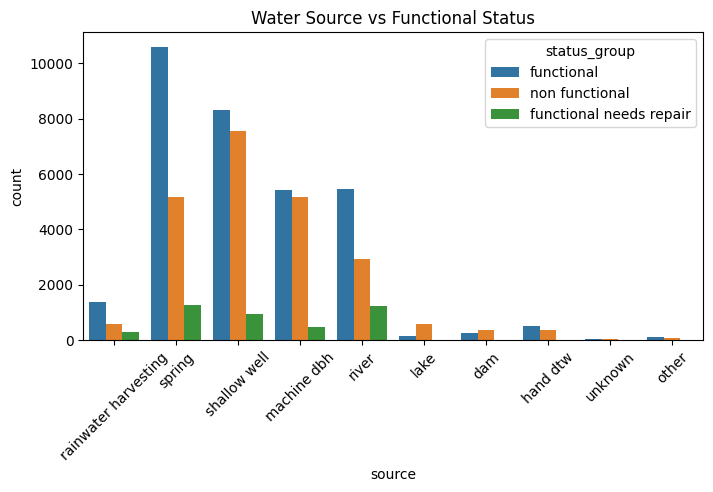

Chi-squared: 2623.998280150263, p-value: 0.0


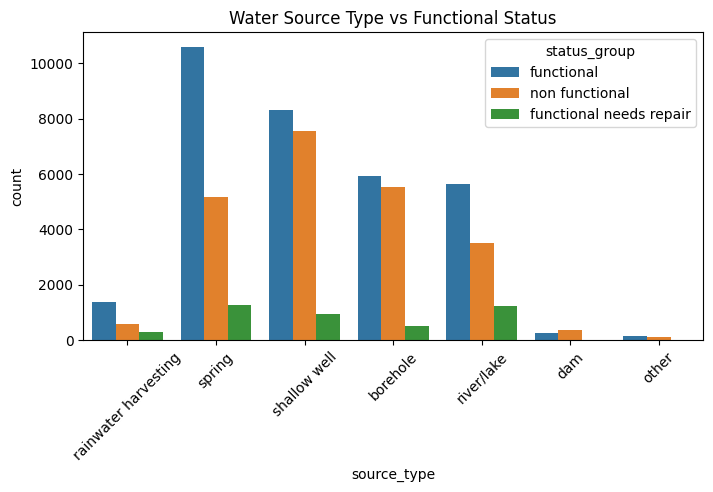

Chi-squared: 1906.7974141394534, p-value: 0.0


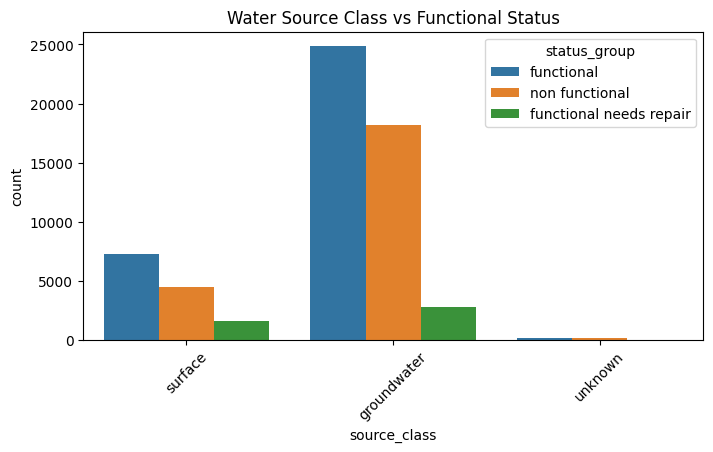

Chi-squared: 590.263287271222, p-value: 1.983538119535751e-126


In [ ]:
# Visualize source vs status_group
plt.figure(figsize=(8, 4))
sns.countplot(x='source', hue='status_group', data=All_data)
plt.title('Water Source vs Functional Status')
plt.xticks(rotation=45)
plt.show()

# Chi-squared test example for 'source'
contingency_table = pd.crosstab(All_data['source'], All_data['status_group'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared: {chi2}, p-value: {p}")

# Visualize source_type vs status_group
plt.figure(figsize=(8, 4))
sns.countplot(x='source_type', hue='status_group', data=All_data)
plt.title('Water Source Type vs Functional Status')
plt.xticks(rotation=45)
plt.show()

# Chi-squared test for 'source_type'
contingency_table = pd.crosstab(All_data['source_type'], All_data['status_group'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared: {chi2}, p-value: {p}")

# Visualize source_class vs status_group
plt.figure(figsize=(8, 4))
sns.countplot(x='source_class', hue='status_group', data=All_data)
plt.title('Water Source Class vs Functional Status')
plt.xticks(rotation=45)
plt.show()

# Chi-squared test for 'source_class'
contingency_table = pd.crosstab(All_data['source_class'], All_data['status_group'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared: {chi2}, p-value: {p}")

The visualizations and the chi-squared test results strongly suggest that all three variables are significantly related to the functional status of the water points. However, `source` and `source_type` provide more detailed breakdowns and show distinctions between different water sources more clearly than `source_class`.

Choosing `source_type` can simplify the model and reduce potential overfitting while retaining enough meaningful information. It reduces complexity without losing significant granularity, as evidenced by the detailed chi-squared test results and its capacity to still differentiate well between functional statuses.

In [ ]:
# Drop the 'source' and 'source_class' colunm
All_data = All_data.drop(['source'], axis=1)
All_data = All_data.drop(['source_class'], axis=1)

In [ ]:
# One hot encoding
All_data = pd.get_dummies(All_data, columns=['source_type'] ,dtype='int_')

In [ ]:
# check the percentage of '0'same_values
result_df = zero_percentage_table(All_data, ['source_type_borehole', 'source_type_dam', 'source_type_other', 'source_type_rainwater harvesting', 'source_type_river/lake', 'source_type_shallow well', 'source_type_spring'])
display(result_df)

,Column,Percentage of 0s
0,source_type_borehole,79.89%
1,source_type_dam,98.87%
2,source_type_other,99.53%
3,source_type_rainwater harvesting,96.14%
4,source_type_river/lake,82.61%
5,source_type_shallow well,71.53%
6,source_type_spring,71.43%


In [ ]:
# Drop 'source_type_other' colunm
All_data = All_data.drop(['source_type_other'], axis=1)

### 3.37 waterpoint_type

In [ ]:
cat_analysis.loc[['waterpoint_type']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
waterpoint_type,object,74250,7,0,0.0,communal standpipe,35628,48.0


In [ ]:
print(All_data['waterpoint_type'].value_counts())

waterpoint_type
communal standpipe             35628
hand pump                      21884
other                           8010
communal standpipe multiple     7611
improved spring                  959
cattle trough                    150
dam                                8
Name: count, dtype: int64


### 3.38 waterpoint_type_group

In [ ]:
cat_analysis.loc[['waterpoint_type_group']]

,Data Type,Records,Unique Values,Missing Values,Missing in %,Mode,Mode freq,Mode in %
waterpoint_type_group,object,74250,6,0,0.0,communal standpipe,43239,58.2


In [ ]:
print(All_data['waterpoint_type_group'].value_counts())

waterpoint_type_group
communal standpipe    43239
hand pump             21884
other                  8010
improved spring         959
cattle trough           150
dam                       8
Name: count, dtype: int64


In [ ]:
# Check mapping from waterpoint_type to waterpoint_type_group
mapping_check_waterpoint = All_data.groupby(['waterpoint_type', 'waterpoint_type_group']).size().reset_index(name='Count')
print(mapping_check_waterpoint)

               waterpoint_type waterpoint_type_group  Count
0                cattle trough         cattle trough    150
1           communal standpipe    communal standpipe  35628
2  communal standpipe multiple    communal standpipe   7611
3                          dam                   dam      8
4                    hand pump             hand pump  21884
5              improved spring       improved spring    959
6                        other                 other   8010


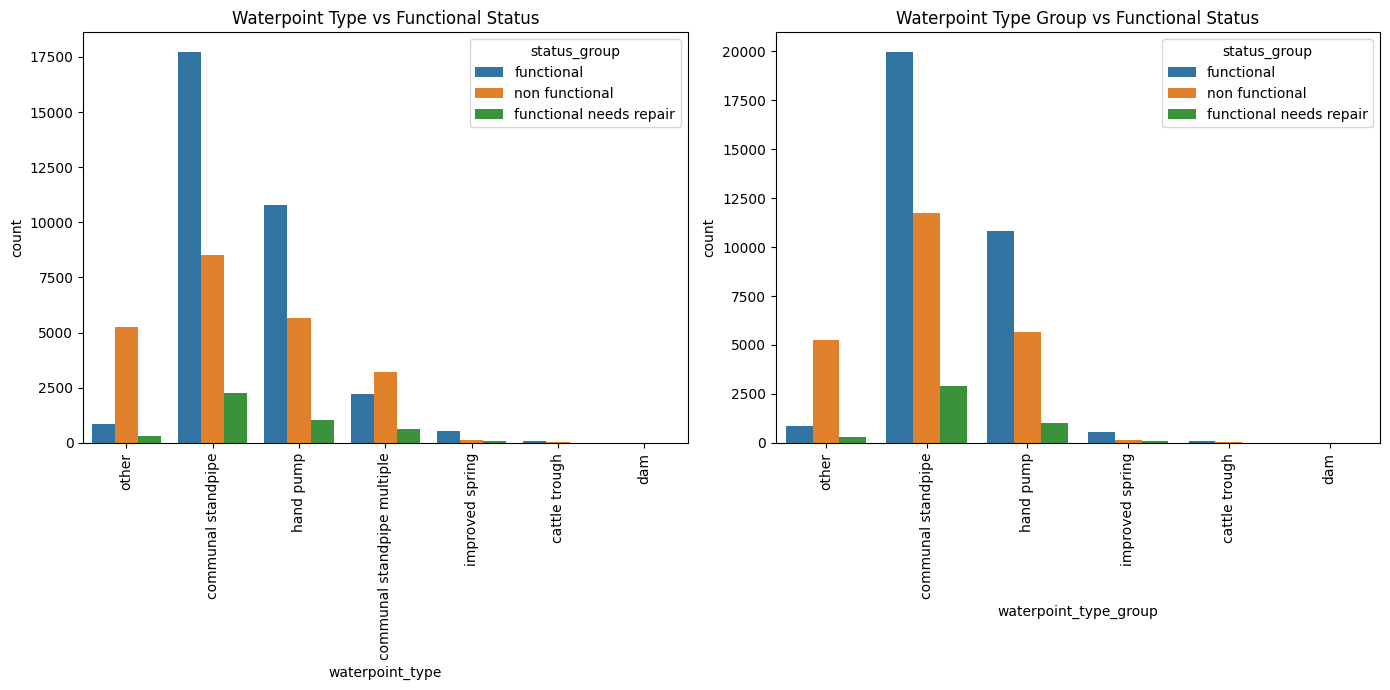

In [ ]:
plt.figure(figsize=(14, 7))

# Waterpoint Type vs. Functional Status
plt.subplot(1, 2, 1)
sns.countplot(data=All_data, x='waterpoint_type', hue='status_group')
plt.title('Waterpoint Type vs Functional Status')
plt.xticks(rotation=90)

# Waterpoint Type Group vs. Functional Status
plt.subplot(1, 2, 2)
sns.countplot(data=All_data, x='waterpoint_type_group', hue='status_group')
plt.title('Waterpoint Type Group vs Functional Status')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Based on the visualizations, retaining the `waterpoint_type` variable would be the better choice. This is because `waterpoint_type` offers a more detailed categorization of the water sources, which provides a finer granularity in the analysis of the relationship between the type of waterpoint and its functional status. 

In [ ]:
# Drop the 'waterpoint_type_group' colunm
All_data = All_data.drop(['waterpoint_type_group'], axis=1)

In [ ]:
# One hot encoding
All_data = pd.get_dummies(All_data, columns=['waterpoint_type'], dtype='int_')

In [ ]:
# check the percentage of '0's
result_df = zero_percentage_table(All_data, ['waterpoint_type_cattle trough', 'waterpoint_type_communal standpipe', 'waterpoint_type_communal standpipe multiple', 'waterpoint_type_dam', 'waterpoint_type_hand pump', 'waterpoint_type_improved spring', 'waterpoint_type_other'])
display(result_df)

,Column,Percentage of 0s
0,waterpoint_type_cattle trough,99.80%
1,waterpoint_type_communal standpipe,52.02%
2,waterpoint_type_communal standpipe multiple,89.75%
3,waterpoint_type_dam,99.99%
4,waterpoint_type_hand pump,70.53%
5,waterpoint_type_improved spring,98.71%
6,waterpoint_type_other,89.21%


In [ ]:
# Drop 'waterpoint_type_dam' and 'waterpoint_type_cattle trough' colunms
All_data = All_data.drop(['waterpoint_type_cattle trough'], axis=1)
All_data = All_data.drop(['waterpoint_type_dam'], axis=1)

**<h3>Save File<h3>**

In [ ]:
All_data.to_csv('Values_Modify.csv')